In [1]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import pandas as pd

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [2]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'MSFT'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [3]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

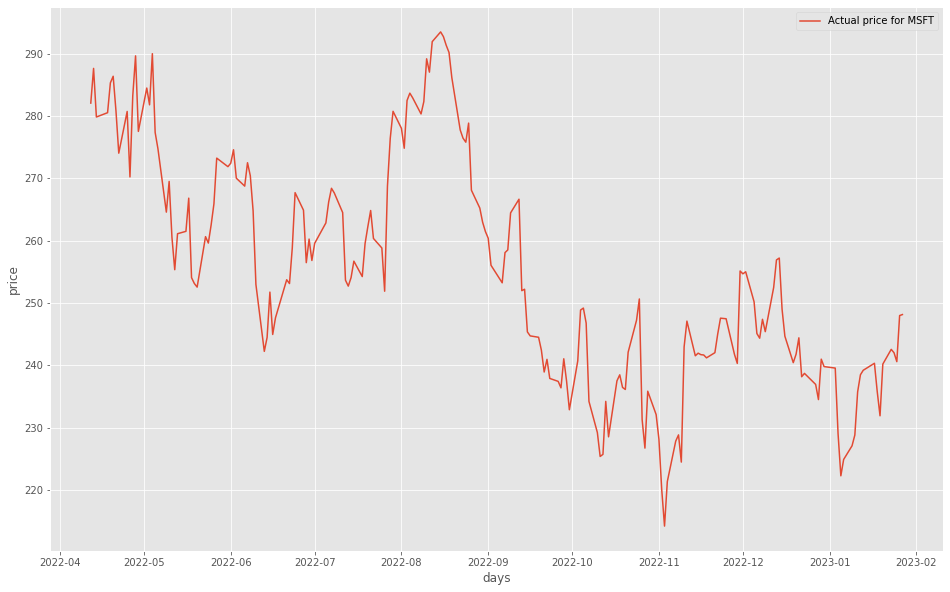

In [4]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [5]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [6]:
def prepare_data(days):
    df = init_df.copy()
    df['future'] = df['close'].shift(-days)
    last_sequence = np.array(df[['close']].tail(days))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return df, last_sequence, X, Y

In [7]:
def get_trained_model(x_train, y_train):
    model = Sequential()
    model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
    model.add(Dropout(0.3))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

    BATCH_SIZE = 8
    EPOCHS = 150

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                verbose=1)

    model.summary()

    return model

In [8]:
# GET PREDICTIONS
predictions = []

In [9]:
for step in LOOKUP_STEPS:
    df, last_sequence, x_train, y_train = prepare_data(step)
    x_train = x_train[:, :, :len(['close'])].astype(np.float32)

    model = get_trained_model(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))

Epoch 93/150
95/95 [==============================] - 1s 9ms/step - loss: 0.0017
Epoch 94/150
95/95 [==============================] - 1s 9ms/step - loss: 0.0017
Epoch 95/150
95/95 [==============================] - 1s 10ms/step - loss: 0.0017
Epoch 96/150
95/95 [==============================] - 1s 9ms/step - loss: 0.0017
Epoch 97/150
95/95 [==============================] - 1s 9ms/step - loss: 0.0018
Epoch 98/150
95/95 [==============================] - 1s 9ms/step - loss: 0.0019
Epoch 99/150
95/95 [==============================] - 1s 9ms/step - loss: 0.0021
Epoch 100/150
95/95 [==============================] - 1s 10ms/step - loss: 0.0018
Epoch 101/150
95/95 [==============================] - 1s 11ms/step - loss: 0.0017
Epoch 102/150
95/95 [==============================] - 1s 11ms/step - loss: 0.0018
Epoch 103/150
95/95 [==============================] - 1s 11ms/step - loss: 0.0018
Epoch 104/150
95/95 [==============================] - 1s 11ms/step - loss: 0.0017
Epoch 105/150
95/

In [10]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

In [11]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

In [12]:
copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0]

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/indexes/base.py:3361: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.get_loc(casted_key)


In [13]:
copy_df.tail(10)

,close,date,predicted_close
2023-01-19 00:00:00,0.464683,2023-01-19 00:00:00,232.206375
2023-01-20 00:00:00,0.504598,2023-01-20 00:00:00,236.564102
2023-01-23 00:00:00,0.515961,2023-01-23 00:00:00,239.067291
2023-01-24 00:00:00,0.513361,2023-01-24 00:00:00,239.592941
2023-01-25 00:00:00,0.506476,2023-01-25 00:00:00,240.610001
2023-01-26 00:00:00,0.542058,2023-01-26 00:00:00,248.000000
2023-01-27 00:00:00,0.542828,2023-01-27 00:00:00,248.160004
2023-01-30,246.990000,2023-01-30,0.000000
2023-01-31,247.780000,2023-01-31,0.000000
2023-02-01,244.840000,2023-02-01,0.000000


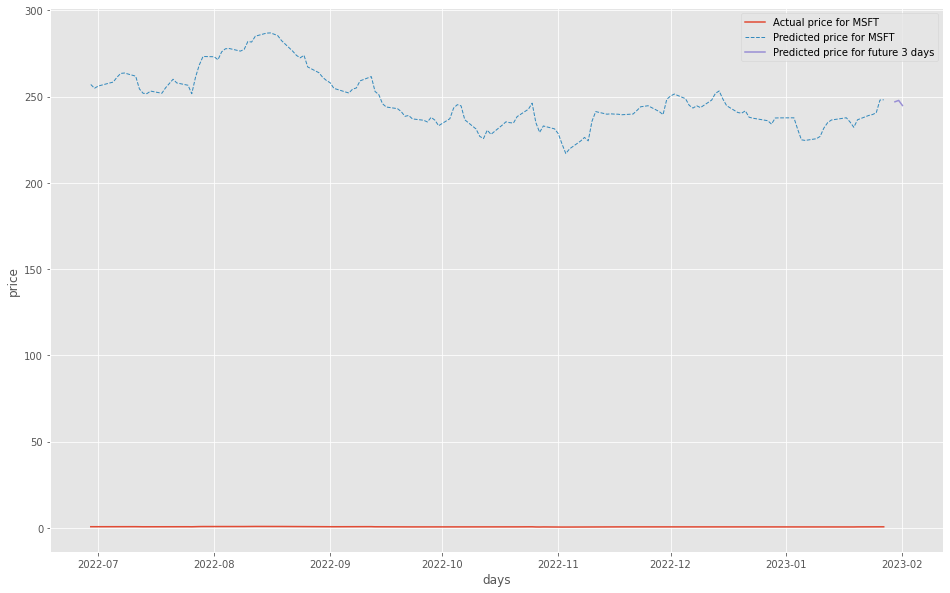

In [14]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(3))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

In [15]:
if bool(predictions) == True and len(predictions) > 0:
    predictions_list = ['$'+str(d) for d in predictions]
    predictions_str = ', '.join(predictions_list)
    message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
    
    print(message)

MSFT prediction for upcoming 3 days ($246.99, $247.78, $244.84)
